## Reconstruction of the curves

The idea - what if we do not need any model, and as the filtered data are already sigmoid, 
can we use some average sigmoid parameters = some averaged values for all the data
1. take the reduced datasets, calculated avearage fitting parameters from the train set
and then reconstruct the drug curve
-for the reconstructed data: R2 and MAE
but MAE for which points? with our filtration criteria first response is from 0.8 to 1, and the last points are les than 0.4 

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

_FOLDER = "results/"
_FOLDER_2 = "figures/"

In [2]:
def sigmoid_4_param(x, x0, L, k, d):
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
        bounds [0, 1]
    L = 1 in Dennis Wang's sigmoid, protect from devision by zero if x is too small 
        L<1 inverted sigmoid, l=100 - lower upper and lower boundso sigmpoid on y axis (y= [0.1, 0.11])
        bounds [0.8, 10]
    k = -1/s (s -shape parameter)  default = -10 k=0 straight line, k<0 sigmoid around k=-10
        bounds [1, -100]
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid
         bounds [0, 0.9]
    parameters_bound ((0, 0.8, -100, 0), (1, 10, 1, 0.9))
    """
    return ( 1/ (L + np.exp(-k*(x-x0))) + d)

def r2_score_sigmoid_4_param(df, x_columns, y_columns, param_columns = []):
    r2_scores=np.zeros(len(df.index))
    for i in range(len(df.index)):
        x = df.loc[df.index[i], x_columns].values.astype(np.float32)
        y = df.loc[df.index[i], y_columns].values.astype(np.float32)
        fit_param = df.loc[df.index[i], param_columns].values.astype(np.float32)
        y_fit = sigmoid_4_param(x, *fit_param)
        r2_scores[i] = r2_score(y, y_fit)
    return r2_scores

def mae_score_sigmoid_4_param(df, x_columns, y_columns, param_columns = []):
    mae_scores=np.zeros(len(df.index))
    for i in range(len(df.index)):
        x = df.loc[df.index[i], x_columns].values.astype(np.float32)
        y = df.loc[df.index[i], y_columns].values.astype(np.float32)
        fit_param = df.loc[df.index[i], param_columns].values.astype(np.float32)
        y_fit = sigmoid_4_param(x, *fit_param)
        mae_scores[i] = mean_absolute_error(y, y_fit)
    return mae_scores


def PrepareData(dict_data_type, training_data_type, X_columns, coefficient):
    with open(dict_data_type[training_data_type]["drug_ids_list"], 'r') as f:
        drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]
    
    train_df = pd.read_csv(dict_data_type[training_data_type]["train_df"]).drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
    test_df = pd.read_csv(dict_data_type[training_data_type]["test_df"]).drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

    train = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
    test = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
    
    y_train = train["param_"+str(coefficient)].values
    y_test =  test["param_"+str(coefficient)].values
    
    scaler = MinMaxScaler().fit(train[X_columns])
    X_train = scaler.transform(train[X_columns])
    X_test = scaler.transform(test[X_columns])
    return X_train, X_test, y_train, y_test

def PrepareDataSets(dict_data_type, training_data_type):
    with open(dict_data_type[training_data_type]["drug_ids_list"], 'r') as f:
        drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]
    
    train_df = pd.read_csv(dict_data_type[training_data_type]["train_df"]).drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
    test_df = pd.read_csv(dict_data_type[training_data_type]["test_df"]).drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)               

    train = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
    test = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

    return train, test, drug_ids_50

def fit_predict_model_performance(df, pred_param_columns, model_type ="", data_type =""):
    
    df["abs_error_param_1"]= abs(df["param_1"] - df[pred_param_columns[0]])
    df["abs_error_param_2"]= abs(df["param_2"] - df[pred_param_columns[1]])
    df["abs_error_param_3"]= abs(df["param_3"] - df[pred_param_columns[2]])
    df["abs_error_param_4"]= abs(df["param_4"] - df[pred_param_columns[3]])

    
    r2_scores = r2_score_sigmoid_4_param(df.reset_index(), 
                                                   x_columns = ["fd_num_"+str(i) for i in range(10)],
                                                  y_columns = ["norm_cells_" + str(i) for i in range(10)],
                                                  param_columns = pred_param_columns)
    mae_scores = mae_score_sigmoid_4_param(df.reset_index(), 
                                                   x_columns = ["fd_num_"+str(i) for i in range(10)],
                                                  y_columns = ["norm_cells_" + str(i) for i in range(10)],
                                                  param_columns = pred_param_columns)

    print("\nDistribution of mean errors for an %s the %s\n" % (model_type, data_type))

    for i in range(1,5):
        print("MAE of parameter %d: %0.3f +/- %0.3f" % (i, df["abs_error_param_" + str(i) +""].mean(),
                                                        df["abs_error_param_" + str(i) +""].std()))
              
    print("\nR2 score for %s and %s: %0.3f +/- %0.3f" % (model_type, data_type, r2_scores.mean(), r2_scores.std()))
    print("\nMAE score for %s and %s: %0.3f +/- %0.3f" % (model_type, data_type, mae_scores.mean(), mae_scores.std()))
    print("\n'Bad' fitted samples (R2<0): %d from %d" % (sum(r2_scores < 0), df.shape[0]))
    return r2_scores, mae_scores

In [3]:
dict_data_type = {
    "original_data": {
        "drug_ids_list": _FOLDER + "drug_ids_50.txt", 
        "train_df" : _FOLDER + "train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv",
        "test_df" : _FOLDER + "test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv"},
    
    "reduced_by_R2_data": {
        "drug_ids_list": _FOLDER +"drug_ids_50_restr.txt", 
        "train_df" : _FOLDER + "train08_min10_restr.csv",
        "test_df" : _FOLDER + "test02_min10_restr.csv"}
}

## Average sigmoid for the Original data

In [4]:
train_df_50, test_df_50, _ = PrepareDataSets(dict_data_type, training_data_type = "original_data")

test_df_50["mean_param_1"] = train_df_50["param_1"].mean() 
test_df_50["mean_param_2"] = train_df_50["param_2"].mean() 
test_df_50["mean_param_3"] = train_df_50["param_3"].mean() 
test_df_50["mean_param_4"] = train_df_50["param_4"].mean() 

r2_scores, mae_scores = fit_predict_model_performance(test_df_50, pred_param_columns=["mean_param_"+str(i) for i in range(1,5)], 
                  model_type ="Average Sigmoid", data_type ="Original Data")


Distribution of mean errors for an Average Sigmoid the Original Data

MAE of parameter 1: 0.308 +/- 1.193
MAE of parameter 2: 0.331 +/- 1.564
MAE of parameter 3: 10.779 +/- 20.932
MAE of parameter 4: 0.089 +/- 0.091

R2 score for Average Sigmoid and Original Data: -0.001 +/- 0.664

MAE score for Average Sigmoid and Original Data: 0.280 +/- 0.086

'Bad' fitted samples (R2<0): 86 from 202


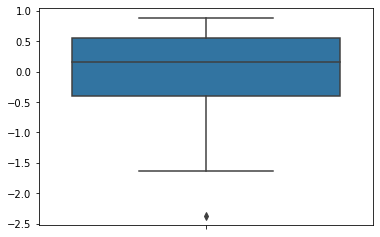

In [5]:
sns.boxplot(y = r2_scores);

## Average sigmoid for the Reduced data

In [6]:
train_df_50, test_df_50, _ = PrepareDataSets(dict_data_type, training_data_type = "reduced_by_R2_data")     

test_df_50["mean_param_1"] = train_df_50["param_1"].mean() 
test_df_50["mean_param_2"] = train_df_50["param_2"].mean() 
test_df_50["mean_param_3"] = train_df_50["param_3"].mean() 
test_df_50["mean_param_4"] = train_df_50["param_4"].mean() 

r2_scores, mae_scores = fit_predict_model_performance(test_df_50, pred_param_columns=["mean_param_"+str(i) for i in range(1,5)], 
                  model_type ="Average Sigmoid", data_type ="Reduced Data")


Distribution of mean errors for an Average Sigmoid the Reduced Data

MAE of parameter 1: 0.117 +/- 0.073
MAE of parameter 2: 0.138 +/- 0.144
MAE of parameter 3: 12.815 +/- 24.340
MAE of parameter 4: 0.096 +/- 0.083

R2 score for Average Sigmoid and Reduced Data: 0.660 +/- 0.426

MAE score for Average Sigmoid and Reduced Data: 0.125 +/- 0.055

'Bad' fitted samples (R2<0): 10 from 185


### General Precision of scipy fitting

In [7]:
from scipy.optimize import curve_fit

In [8]:
train_df_50, test_df_50, _ = PrepareDataSets(dict_data_type, training_data_type = "original_data")

df_drug = pd.DataFrame()
for i in range(10):
    df_concat_test = pd.concat([df_drug, train_df_50[["COSMIC_ID", "fd_num_"+str(i), "norm_cells_"+str(i)]].rename(
                                    columns={"fd_num_"+str(i): "scaled_x", 
                                             "norm_cells_"+str(i): "norm_y"})],
                                    axis=0, ignore_index = True) 
fitting_function = sigmoid_4_param
x = df_concat_test["scaled_x"]
y = df_concat_test["norm_y"]
# parameters_guess = [0.4, 1.0, 1.0, .0]
parameters_guess = [0.4, 1.0, -10, .0]
parameters, p_covariance = curve_fit(fitting_function, x, y, parameters_guess)
print(parameters)
test_df_50["fit_param_1"] = parameters[0]
test_df_50["fit_param_2"] = parameters[1]
test_df_50["fit_param_3"] = parameters[2]
test_df_50["fit_param_4"] = parameters[3]

r2_scores, mae_scores = fit_predict_model_performance(test_df_50, pred_param_columns=["fit_param_"+str(i) for i in range(1,5)], 
                  model_type ="General fitting", data_type ="Original Data")

[3.51862652e+00 2.27271838e+04 4.21581163e+01 9.46426788e-02]

Distribution of mean errors for an General fitting the Original Data

MAE of parameter 1: 3.108 +/- 0.665
MAE of parameter 2: 22726.215 +/- 1.598
MAE of parameter 3: 62.193 +/- 23.549
MAE of parameter 4: 0.095 +/- 0.086

R2 score for General fitting and Original Data: -1.497 +/- 1.247

MAE score for General fitting and Original Data: 0.446 +/- 0.087

'Bad' fitted samples (R2<0): 202 from 202


In [9]:
train_df_50, test_df_50, _ = PrepareDataSets(dict_data_type, training_data_type = "reduced_by_R2_data")    

df_drug = pd.DataFrame()
df_concat_test = pd.concat([df_drug, train_df_50[["COSMIC_ID", "fd_num_"+str(i), "norm_cells_"+str(i)]].rename(
                                    columns={"fd_num_"+str(i): "scaled_x", 
                                             "norm_cells_"+str(i): "norm_y"})],
                                    axis=0, ignore_index = True) 
fitting_function = sigmoid_4_param
x = df_concat_test["scaled_x"]
y = df_concat_test["norm_y"]
# parameters_guess = [0.4, 1.0, 1.0, .0]
parameters_guess = [0.4, 1.0, -10, .0]
parameters, p_covariance = curve_fit(fitting_function, x, y, parameters_guess)

test_df_50["fit_param_1"] = parameters[0]
test_df_50["fit_param_2"] = parameters[1]
test_df_50["fit_param_3"] = parameters[2]
test_df_50["fit_param_4"] = parameters[3]

r2_scores, mae_scores = fit_predict_model_performance(test_df_50, pred_param_columns=["fit_param_"+str(i) for i in range(1,5)], 
                  model_type ="General fitting", data_type ="Reduced Data")


Distribution of mean errors for an General fitting the Reduced Data

MAE of parameter 1: 3.012 +/- 0.138
MAE of parameter 2: 22815.827 +/- 0.200
MAE of parameter 3: 63.835 +/- 27.301
MAE of parameter 4: 0.100 +/- 0.078

R2 score for General fitting and Reduced Data: -1.684 +/- 1.454

MAE score for General fitting and Reduced Data: 0.455 +/- 0.093

'Bad' fitted samples (R2<0): 185 from 185


In [10]:
train_df_50, _, _ = PrepareDataSets(dict_data_type, training_data_type = "reduced_by_R2_data")  
_, test_df_50, _ = PrepareDataSets(dict_data_type, training_data_type = "original_data")

df_drug = pd.DataFrame()
df_concat_test = pd.concat([df_drug, train_df_50[["COSMIC_ID", "fd_num_"+str(i), "norm_cells_"+str(i)]].rename(
                                    columns={"fd_num_"+str(i): "scaled_x", 
                                             "norm_cells_"+str(i): "norm_y"})],
                                    axis=0, ignore_index = True) 
fitting_function = sigmoid_4_param
x = df_concat_test["scaled_x"]
y = df_concat_test["norm_y"]
# parameters_guess = [0.4, 1.0, 1.0, .0]
parameters_guess = [0.4, 1.0, -10, .0]
parameters, p_covariance = curve_fit(fitting_function, x, y, parameters_guess)

test_df_50["fit_param_1"] = parameters[0]
test_df_50["fit_param_2"] = parameters[1]
test_df_50["fit_param_3"] = parameters[2]
test_df_50["fit_param_4"] = parameters[3]

r2_scores, mae_scores = fit_predict_model_performance(test_df_50, pred_param_columns=["fit_param_"+str(i) for i in range(1,5)], 
                  model_type ="General fitting", data_type ="Reduced Data(Training)/Original Data(Testing)")


Distribution of mean errors for an General fitting the Reduced Data(Training)/Original Data(Testing)

MAE of parameter 1: 3.068 +/- 0.672
MAE of parameter 2: 22815.982 +/- 1.598
MAE of parameter 3: 61.506 +/- 23.549
MAE of parameter 4: 0.094 +/- 0.087

R2 score for General fitting and Reduced Data(Training)/Original Data(Testing): -1.520 +/- 1.260

MAE score for General fitting and Reduced Data(Training)/Original Data(Testing): 0.448 +/- 0.088

'Bad' fitted samples (R2<0): 202 from 202


## Reconstruction with built Models

In [11]:
with open(_FOLDER+"X_features_cancer_cell_lines.txt", 'r') as f:
    X_cancer_cell_lines = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_PubChem_properties.txt", 'r') as f:
    X_PubChem_properties = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_features_Targets.txt", 'r') as f:
    X_targets = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_features_Target_Pathway.txt", 'r') as f:
    X_target_pathway = [line.rstrip('\n') for line in f]
# *****************************************

all_columns = X_cancer_cell_lines + X_PubChem_properties + X_targets + X_target_pathway +["MAX_CONC"]

datasets = ["Dataset 1", "Dataset 2", "Dataset 3", "Dataset 4"]

X_feat_dict = {"Dataset 1": X_cancer_cell_lines ,
               "Dataset 2": ["MAX_CONC"] + X_targets + X_target_pathway + X_cancer_cell_lines ,
               "Dataset 3": ["MAX_CONC"] + X_PubChem_properties +  X_cancer_cell_lines,
               "Dataset 4": ["MAX_CONC"] + X_PubChem_properties +  X_targets + X_target_pathway + X_cancer_cell_lines}

In [12]:
def TrainPredict_KR_drug_by_drug(train, test, target, drug_ids_list, X_columns, kernel, hyperparameters, degree = 3):
    y_pred = []
    for drug_id in drug_ids_list:
        train_drug = train.loc[drug_id,:]
        test_drug = test.loc[drug_id,:]
        y_train_drug = train_drug[target].values
        y_test_drug =  test_drug[target].values
        scaler = MinMaxScaler().fit(train_drug[X_columns])
        Xtrain_drug = scaler.transform(train_drug[X_columns])
        
        if kernel == "polynomial":
            model = KernelRidge(kernel = kernel, 
                        alpha = hyperparameters.loc[drug_id, "best_alpha3"], 
                        gamma = hyperparameters.loc[drug_id, "best_gamma3"],
                        coef0= hyperparameters.loc[drug_id, "best_coef03"], 
                        degree = hyperparameters.loc[drug_id, "best_degree3"])
        elif kernel == "linear":
            model = KernelRidge(kernel = kernel, 
                        alpha = hyperparameters.loc[drug_id, "best_alpha3"], 
                        coef0= hyperparameters.loc[drug_id, "best_coef03"])
        else:
            model = KernelRidge(kernel = kernel, 
                        alpha = hyperparameters.loc[drug_id, "best_alpha3"], 
                        gamma = hyperparameters.loc[drug_id, "best_gamma3"],
                        coef0= hyperparameters.loc[drug_id, "best_coef03"])
            
        model.fit(Xtrain_drug, y_train_drug)
        Xtest_drug = scaler.transform(test_drug[X_columns])
        
        y_pred.extend(model.predict(Xtest_drug))
    return y_pred


def TrainPredict_SVR_drug_by_drug(train, test, target, drug_ids_list, X_columns, kernel, hyperparameters, degree = 3):
    y_pred = []
    for drug_id in drug_ids_list:
        train_drug = train.loc[drug_id,:]
        test_drug = test.loc[drug_id,:]
        y_train_drug = train_drug[target].values
        y_test_drug =  test_drug[target].values
        scaler = MinMaxScaler().fit(train_drug[X_columns])
        Xtrain_drug = scaler.transform(train_drug[X_columns])
        
        if kernel !="linear":
            model = SVR(kernel = kernel, 
                C= hyperparameters.loc[drug_id, "best_C3"], 
                epsilon = hyperparameters.loc[drug_id, "best_epsilon3"],
                coef0= hyperparameters.loc[drug_id, "best_coef03"])
        else:
            model = SVR(kernel = kernel, 
                C= hyperparameters.loc[drug_id, "best_C3"], 
                epsilon = hyperparameters.loc[drug_id, "best_epsilon3"]) 
            
        
        model.fit(Xtrain_drug, y_train_drug)
        Xtest_drug = scaler.transform(test_drug[X_columns])
        
        y_pred.extend(model.predict(Xtest_drug))
    return y_pred

## Training on the Original data

In [13]:
train_df_50, test_df_50, drug_ids_50 = PrepareDataSets(dict_data_type, training_data_type = "original_data")

print("\nDrug-by-drug training\n")
# Poly KR
i=1
hyperparameters = pd.read_csv(_FOLDER+"best_model_coef_1.csv").drop(["Unnamed: 0"], axis=1).set_index("DRUG_ID")

kernel = "polynomial"
test_df_50["pred_param_1"]= TrainPredict_KR_drug_by_drug(train = train_df_50, test = test_df_50, target = "param_1", 
                                                         drug_ids_list = drug_ids_50, X_columns = X_feat_dict["Dataset 4"],
                                                         kernel =kernel, hyperparameters = hyperparameters)
# RBF SVR
i=2
hyperparameters = pd.read_csv(_FOLDER+"best_model_coef_2.csv").drop(["Unnamed: 0"], axis=1).set_index("DRUG_ID")

kernel = "rbf"
test_df_50["pred_param_2"]= TrainPredict_SVR_drug_by_drug(train = train_df_50, test = test_df_50, target = "param_2", 
                                                         drug_ids_list = drug_ids_50, X_columns = X_feat_dict["Dataset 4"],
                                                         kernel =kernel, hyperparameters = hyperparameters)
# Linear SVR
i=3
hyperparameters = pd.read_csv(_FOLDER+"best_model_coef_3.csv").drop(["Unnamed: 0"], axis=1).set_index("DRUG_ID")

kernel = "linear"
test_df_50["pred_param_3"]= TrainPredict_SVR_drug_by_drug(train = train_df_50, test = test_df_50, target = "param_3", 
                                                         drug_ids_list = drug_ids_50, X_columns = X_feat_dict["Dataset 4"],
                                                         kernel =kernel, hyperparameters = hyperparameters)
# RBF KR
i=4
hyperparameters = pd.read_csv(_FOLDER+"best_model_coef_4.csv").drop(["Unnamed: 0"], axis=1).set_index("DRUG_ID")

kernel = "rbf"
test_df_50["pred_param_4"]= TrainPredict_KR_drug_by_drug(train = train_df_50, test = test_df_50, target = "param_4", 
                                                         drug_ids_list = drug_ids_50, X_columns = X_feat_dict["Dataset 4"],
                                                         kernel =kernel, hyperparameters = hyperparameters)

r2_scores, abs_errors_all = fit_predict_model_performance(test_df_50, pred_param_columns=["pred_param_"+str(i) for i in range(1,5)], 
                  model_type ="Algorithm 1", data_type ="Original Data")

### All drugs training
print("\n\nAll drugs training\n")

X_columns = X_feat_dict["Dataset 4"]
scaler = MinMaxScaler().fit(train_df_50[X_columns])
X_train = scaler.transform(train_df_50[X_columns])
X_test = scaler.transform(test_df_50[X_columns])

i=1
y_train = train_df_50["param_1"].values
y_test =  test_df_50["param_1"].values
#RBF SVR
i=1
kernel ="rbf"
C= 0.5
epsilon = 0.01
coef0 = 0.01
model = SVR(kernel = kernel, epsilon = epsilon, C=C, coef0 = coef0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 
test_df_50["pred_param_1"] = y_pred

i=2
y_train = train_df_50["param_2"].values
y_test=  test_df_50["param_2"].values
#RBF SVR
i=2
kernel ="rbf"
C= 0.1
epsilon = 0.01
coef0 = 0.01
model = SVR(kernel = kernel, epsilon = epsilon, C=C, coef0 = coef0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_df_50["pred_param_2"] = y_pred

i=3
y_train = train_df_50["param_3"].values
y_test=  test_df_50["param_3"].values 

#Linear SVR
i=3
kernel ="linear"
C = 0.1
epsilon = 1
model = SVR(kernel = kernel, epsilon = epsilon, C=C)
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 
test_df_50["pred_param_3"] = y_pred

i=4
y_train = train_df_50["param_4"].values
y_test=  test_df_50["param_4"].values

#RBF SVR
i=4
kernel ="rbf"
C= 0.1
epsilon = 0.001
coef0 = 0.01
model = SVR(kernel = kernel, epsilon = epsilon, C=C, coef0 = coef0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_df_50["pred_param_4"] = y_pred

r2_scores, mae_scores = fit_predict_model_performance(test_df_50, pred_param_columns=["pred_param_"+str(i) for i in range(1,5)], 
                  model_type ="Algorithm 2", data_type ="Original Data")

## Training on the Reduced data

train_df_50, test_df_50, drug_ids_50 = PrepareDataSets(dict_data_type, training_data_type = "reduced_by_R2_data")

print("\nDrug-by-drug training\n")
# Poly KR
i=1
hyperparameters = pd.read_csv(_FOLDER+"best_model_coef_1.csv").drop(["Unnamed: 0"], axis=1).set_index("DRUG_ID")

kernel = "polynomial"
test_df_50["pred_param_1"]= TrainPredict_KR_drug_by_drug(train = train_df_50, test = test_df_50, target = "param_1", 
                                                         drug_ids_list = drug_ids_50, X_columns = X_feat_dict["Dataset 4"],
                                                         kernel =kernel, hyperparameters = hyperparameters)
# RBF SVR
i=2
hyperparameters = pd.read_csv(_FOLDER+"best_model_coef_2.csv").drop(["Unnamed: 0"], axis=1).set_index("DRUG_ID")

kernel = "rbf"
test_df_50["pred_param_2"]= TrainPredict_SVR_drug_by_drug(train = train_df_50, test = test_df_50, target = "param_2", 
                                                         drug_ids_list = drug_ids_50, X_columns = X_feat_dict["Dataset 4"],
                                                         kernel =kernel, hyperparameters = hyperparameters)
# Linear SVR
i=3
hyperparameters = pd.read_csv(_FOLDER+"best_model_coef_3.csv").drop(["Unnamed: 0"], axis=1).set_index("DRUG_ID")

kernel = "linear"
test_df_50["pred_param_3"]= TrainPredict_SVR_drug_by_drug(train = train_df_50, test = test_df_50, target = "param_3", 
                                                         drug_ids_list = drug_ids_50, X_columns = X_feat_dict["Dataset 4"],
                                                         kernel =kernel, hyperparameters = hyperparameters)
# RBF KR
i=4
hyperparameters = pd.read_csv(_FOLDER+"best_model_coef_4.csv").drop(["Unnamed: 0"], axis=1).set_index("DRUG_ID")

kernel = "rbf"
test_df_50["pred_param_4"]= TrainPredict_KR_drug_by_drug(train = train_df_50, test = test_df_50, target = "param_4", 
                                                         drug_ids_list = drug_ids_50, X_columns = X_feat_dict["Dataset 4"],
                                                         kernel =kernel, hyperparameters = hyperparameters)

r2_scores, mae_scores = fit_predict_model_performance(test_df_50, pred_param_columns=["pred_param_"+str(i) for i in range(1,5)], 
                  model_type ="Algorithm 1", data_type ="Original Data")

### All drugs training
print("\n\nAll drugs training\n")

X_columns = X_feat_dict["Dataset 4"]
scaler = MinMaxScaler().fit(train_df_50[X_columns])
X_train = scaler.transform(train_df_50[X_columns])
X_test = scaler.transform(test_df_50[X_columns])

i=1
y_train = train_df_50["param_1"].values
y_test =  test_df_50["param_1"].values
#RBF SVR
i=1
kernel ="rbf"
C= 0.5
epsilon = 0.01
coef0 = 0.01
model = SVR(kernel = kernel, epsilon = epsilon, C=C, coef0 = coef0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 
test_df_50["pred_param_1"] = y_pred

i=2
y_train = train_df_50["param_2"].values
y_test=  test_df_50["param_2"].values
#RBF SVR
i=2
kernel ="rbf"
C= 0.1
epsilon = 0.01
coef0 = 0.01
model = SVR(kernel = kernel, epsilon = epsilon, C=C, coef0 = coef0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_df_50["pred_param_2"] = y_pred

i=3
y_train = train_df_50["param_3"].values
y_test=  test_df_50["param_3"].values 

#Linear SVR
i=3
kernel ="linear"
C = 0.1
epsilon = 1
model = SVR(kernel = kernel, epsilon = epsilon, C=C)
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 
test_df_50["pred_param_3"] = y_pred

i=4
y_train = train_df_50["param_4"].values
y_test=  test_df_50["param_4"].values

#RBF SVR
i=4
kernel ="rbf"
C= 0.1
epsilon = 0.001
coef0 = 0.01
model = SVR(kernel = kernel, epsilon = epsilon, C=C, coef0 = coef0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_df_50["pred_param_4"] = y_pred

r2_scores, mae_scores = fit_predict_model_performance(test_df_50, pred_param_columns=["pred_param_"+str(i) for i in range(1,5)], 
                  model_type ="Algorithm 2", data_type ="Reduced by R2 Data")


Drug-by-drug training


Distribution of mean errors for an Algorithm 1 the Original Data

MAE of parameter 1: 0.208 +/- 1.228
MAE of parameter 2: 0.231 +/- 1.585
MAE of parameter 3: 8.529 +/- 21.913
MAE of parameter 4: 0.069 +/- 0.087

R2 score for Algorithm 1 and Original Data: 0.786 +/- 0.270

MAE score for Algorithm 1 and Original Data: 0.103 +/- 0.051

'Bad' fitted samples (R2<0): 6 from 202


All drugs training


Distribution of mean errors for an Algorithm 2 the Original Data

MAE of parameter 1: 0.208 +/- 1.230
MAE of parameter 2: 0.236 +/- 1.585
MAE of parameter 3: 8.952 +/- 22.089
MAE of parameter 4: 0.072 +/- 0.099

R2 score for Algorithm 2 and Original Data: 0.767 +/- 0.355

MAE score for Algorithm 2 and Original Data: 0.101 +/- 0.054

'Bad' fitted samples (R2<0): 7 from 202

Drug-by-drug training


Distribution of mean errors for an Algorithm 1 the Original Data

MAE of parameter 1: 0.134 +/- 0.095
MAE of parameter 2: 0.113 +/- 0.140
MAE of parameter 3: 10.657 +/- 25.178
M

## Final testing on the unseen data

train on the data for drug_ids_50, 
but test on the data not from drug_ids_50

In [14]:
training_data_type = "original_data"
with open(dict_data_type[training_data_type]["drug_ids_list"], 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]
    
train_df = pd.read_csv(dict_data_type[training_data_type]["train_df"]).drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(dict_data_type[training_data_type]["test_df"]).drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)

not_drug_ids_50 = list(set(test_df["DRUG_ID"].unique()) -set(drug_ids_50))
len(not_drug_ids_50)

test_df.set_index("DRUG_ID").loc[drug_ids_50, :].shape, test_df.set_index("DRUG_ID").loc[not_drug_ids_50, :].shape

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[not_drug_ids_50, :].fillna(0).copy()

for col in test_df_50.columns:
    if test_df_50[col].isnull().sum()!=0:
        print(col)

## All drugs training
print("\nAll drugs training\n")

X_columns = X_feat_dict["Dataset 4"]
scaler = MinMaxScaler().fit(train_df_50[X_columns])
X_train = scaler.transform(train_df_50[X_columns])
X_test = scaler.transform(test_df_50[X_columns])

i=1
y_train = train_df_50["param_1"].values
y_test =  test_df_50["param_1"].values

#RBF SVR
i=1
kernel ="rbf"
C= 0.5
epsilon = 0.01
coef0 = 0.01
model = SVR(kernel = kernel, epsilon = epsilon, C=C, coef0 = coef0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 
test_df_50["pred_param_1"] = y_pred

#**************************************

i=2
y_train = train_df_50["param_2"].values
y_test =  test_df_50["param_2"].values
#RBF SVR
i=2
kernel ="rbf"
C= 0.1
epsilon = 0.01
coef0 = 0.01
model = SVR(kernel = kernel, epsilon = epsilon, C=C, coef0 = coef0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_df_50["pred_param_2"] = y_pred

#**************************************

i=3
y_train = train_df_50["param_3"].values
y_test =  test_df_50["param_3"].values 

#Linear SVR
i=3
kernel ="linear"
C = 0.1
epsilon = 1
model = SVR(kernel = kernel, epsilon = epsilon, C=C)
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 
test_df_50["pred_param_3"] = y_pred

#**************************************

i=4
y_train = train_df_50["param_4"].values
y_test =  test_df_50["param_4"].values

#RBF SVR
i=4
kernel ="rbf"
C= 0.1
epsilon = 0.001
coef0 = 0.01
model = SVR(kernel = kernel, epsilon = epsilon, C=C, coef0 = coef0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_df_50["pred_param_4"] = y_pred
#**************************************

r2_scores, mae_scores = fit_predict_model_performance(test_df_50, pred_param_columns=["pred_param_"+str(i) for i in range(1,5)], 
                  model_type ="Algorithm 2", data_type ="Unseen Data")


All drugs training


Distribution of mean errors for an Algorithm 2 the Unseen Data

MAE of parameter 1: 0.253 +/- 1.058
MAE of parameter 2: 0.253 +/- 1.248
MAE of parameter 3: 12.465 +/- 26.390
MAE of parameter 4: 0.150 +/- 0.497

R2 score for Algorithm 2 and Unseen Data: 0.496 +/- 0.554

MAE score for Algorithm 2 and Unseen Data: 0.148 +/- 0.071

'Bad' fitted samples (R2<0): 50 from 294


### Check MAE for each drug dosage

In [15]:
fit_param = test_df_50[["pred_param_" +str(i) for i in range(1,5)]]

abs_errors_all =[]
for i in range(9):
    y_fit = sigmoid_4_param(test_df_50["fd_num_"+str(i)], test_df_50["pred_param_1"], test_df_50["pred_param_2"], test_df_50["pred_param_3"], test_df_50["pred_param_4"])
    abs_errors = abs(test_df_50["norm_cells_"+str(i)]- y_fit)
    test_df_50["abs_error_"+str(i)]= abs_errors
    test_df_50["rel_error_"+str(i)]= test_df_50["abs_error_"+str(i)]*100/(test_df_50["norm_cells_"+str(i)])
    abs_errors_all.append(abs_errors)

In [16]:
round(test_df_50[["abs_error_"+str(i) for i in range(9)]].max(axis=0),3)

abs_error_0    0.042
abs_error_1    0.118
abs_error_2    0.618
abs_error_3    0.753
abs_error_4    0.796
abs_error_5    0.892
abs_error_6    0.928
abs_error_7    0.917
abs_error_8    0.391
dtype: float64

MAE: 0.155 +/- 0.185


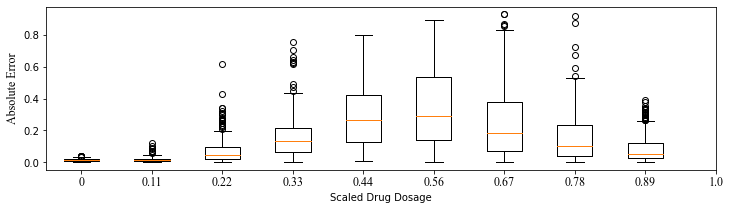

In [17]:
drug_dosage = test_df_50.reset_index().loc[0,["fd_num_"+str(i) for i in range(10)]].values
for i in range(len(drug_dosage+1)):
    drug_dosage[i] = round(drug_dosage[i],2)

csfont = {'fontname':'Times New Roman'}
plt.figure(figsize=(12,3))
# x = test_df_50[["abs_error_"+str(i) for i in range(9)]].values
x = abs_errors_all
plt.boxplot(x)
plt.ylabel("Absolute Error", fontsize=12, **csfont)
plt.xticks(list(range(1, 11)), drug_dosage, fontsize=12, **csfont)
plt.xlabel("Scaled Drug Dosage")
plt.savefig(_FOLDER_2+"final_errors.png", bbox_inches='tight');

ae = np.array(abs_errors_all).flatten()
print("MAE:", round(ae.mean(), 3), "+/-", round(ae.std(), 3))

## Testing on all the filtered data (known and unknown drugs)

In [18]:
training_data_type = "original_data"
with open(dict_data_type[training_data_type]["drug_ids_list"], 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]
    
train_df = pd.read_csv(dict_data_type[training_data_type]["train_df"]).drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(dict_data_type[training_data_type]["test_df"]).drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)

In [19]:
test_df[["DRUG_ID", "COSMIC_ID", "MAX_CONC"]+["fd_num_"+str(i) for i in range(10)]+["norm_cells_"+str(i) for i in range(10)]].to_csv("Original_data.csv")

In [20]:
## All drugs training

train_drug = train_df.set_index("DRUG_ID").fillna(0).copy()
test_drug = test_df.set_index("DRUG_ID").fillna(0).copy()

print("\nAll drugs training\n")

X_columns = X_feat_dict["Dataset 4"]
scaler = MinMaxScaler().fit(train_drug[X_columns])
Xtrain_drug = scaler.transform(train_drug[X_columns])
Xtest_drug = scaler.transform(test_drug[X_columns])

i=1
y_train_drug = train_drug["param_1"].values
y_test_drug =  test_drug["param_1"].values
#RBF SVR
i=1
kernel ="rbf"
C= 0.5
epsilon = 0.01
coef0 = 0.01
model = SVR(kernel = kernel, epsilon = epsilon, C=C, coef0 = coef0)
model.fit(Xtrain_drug, y_train_drug)
y_pred = model.predict(Xtest_drug) 
test_drug["pred_param_1"] = y_pred

#**************************************

i=2
y_train_drug = train_drug["param_2"].values
y_test_drug =  test_drug["param_2"].values
#RBF SVR
i=2
kernel ="rbf"
C= 0.1
epsilon = 0.01
coef0 = 0.01
model = SVR(kernel = kernel, epsilon = epsilon, C=C, coef0 = coef0)
model.fit(Xtrain_drug, y_train_drug)
y_pred = model.predict(Xtest_drug)
test_drug["pred_param_2"] = y_pred

#**************************************

i=3
y_train_drug = train_drug["param_3"].values
y_test_drug =  test_drug["param_3"].values 

#Linear SVR
i=3
kernel ="linear"
C = 0.1
epsilon = 1
model = SVR(kernel = kernel, epsilon = epsilon, C=C)
model.fit(Xtrain_drug, y_train_drug)
y_pred = model.predict(Xtest_drug) 
test_drug["pred_param_3"] = y_pred

#**************************************

i=4
y = test_drug["param_4"]
y_train_drug = train_drug["param_4"].values
y_test_drug =  test_drug["param_4"].values

#RBF SVR
i=4
kernel ="rbf"
C= 0.1
epsilon = 0.001
coef0 = 0.01
model = SVR(kernel = kernel, epsilon = epsilon, C=C, coef0 = coef0)
model.fit(Xtrain_drug, y_train_drug)
y_pred = model.predict(Xtest_drug)
test_drug["pred_param_4"] = y_pred

#**************************************

r2_scores, abs_errors_all = fit_predict_model_performance(test_df_50, pred_param_columns=["pred_param_"+str(i) for i in range(1,5)], 
                  model_type ="Algorithm 2", data_type ="All testing Data")


All drugs training


Distribution of mean errors for an Algorithm 2 the All testing Data

MAE of parameter 1: 0.253 +/- 1.058
MAE of parameter 2: 0.253 +/- 1.248
MAE of parameter 3: 12.465 +/- 26.390
MAE of parameter 4: 0.150 +/- 0.497

R2 score for Algorithm 2 and All testing Data: 0.496 +/- 0.554

MAE score for Algorithm 2 and All testing Data: 0.148 +/- 0.071

'Bad' fitted samples (R2<0): 50 from 294


## All drugs training on all drugs - worser results

In [21]:
## All drugs training on all filtered drugs
train_drug = pd.read_csv(_FOLDER + "train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1).fillna(0)
test_drug = pd.read_csv(_FOLDER + "test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1).fillna(0)

In [22]:
print("\nAll drugs training\n")

X_columns = X_feat_dict["Dataset 4"]
scaler = MinMaxScaler().fit(train_drug[X_columns])
Xtrain_drug = scaler.transform(train_drug[X_columns])
Xtest_drug = scaler.transform(test_drug[X_columns])

i=1
y_train_drug = train_drug["param_1"].values
y_test_drug =  test_drug["param_1"].values
#RBF SVR
i=1
kernel ="rbf"
C= 0.5
epsilon = 0.01
coef0 = 0.01
model = SVR(kernel = kernel, epsilon = epsilon, C=C, coef0 = coef0)
model.fit(Xtrain_drug, y_train_drug)
y_pred = model.predict(Xtest_drug) 
test_drug["pred_param_1"] = y_pred

#**************************************

i=2
y_train_drug = train_drug["param_2"].values
y_test_drug =  test_drug["param_2"].values
#RBF SVR
i=2
kernel ="rbf"
C= 0.1
epsilon = 0.01
coef0 = 0.01
model = SVR(kernel = kernel, epsilon = epsilon, C=C, coef0 = coef0)
model.fit(Xtrain_drug, y_train_drug)
y_pred = model.predict(Xtest_drug)
test_drug["pred_param_2"] = y_pred


#**************************************

i=3
y = test_drug["param_3"]
y_train_drug = train_drug["param_3"].values
y_test_drug =  test_drug["param_3"].values 

#Linear SVR
i=3
kernel ="linear"
C = 0.1
epsilon = 1
model = SVR(kernel = kernel, epsilon = epsilon, C=C)
model.fit(Xtrain_drug, y_train_drug)
y_pred = model.predict(Xtest_drug) 
test_drug["pred_param_3"] = y_pred


#**************************************

i=4
y_train_drug = train_drug["param_4"].values
y_test_drug =  test_drug["param_4"].values

#RBF SVR
i=4
kernel ="rbf"
C= 0.1
epsilon = 0.001
coef0 = 0.01
model = SVR(kernel = kernel, epsilon = epsilon, C=C, coef0 = coef0)
model.fit(Xtrain_drug, y_train_drug)
y_pred = model.predict(Xtest_drug)
test_drug["pred_param_4"] = y_pred


#**************************************


r2_scores, abs_errors_all = fit_predict_model_performance(test_df_50, pred_param_columns=["pred_param_"+str(i) for i in range(1,5)], 
                  model_type ="Algorithm 2", data_type ="All testing Data")


All drugs training


Distribution of mean errors for an Algorithm 2 the All testing Data

MAE of parameter 1: 0.253 +/- 1.058
MAE of parameter 2: 0.253 +/- 1.248
MAE of parameter 3: 12.465 +/- 26.390
MAE of parameter 4: 0.150 +/- 0.497

R2 score for Algorithm 2 and All testing Data: 0.496 +/- 0.554

MAE score for Algorithm 2 and All testing Data: 0.148 +/- 0.071

'Bad' fitted samples (R2<0): 50 from 294
